#### Fundamentals of ML - *Santiago Cuevas*

# Report 2 - *Classifying with convnets*

### **Problem:**

You will work with an image dataset (see below for details). Your task is two-fold:
1. Build a baseline classification pipeline with a classic machine learning algorithm (i.e. not
based on a neural network) of your choosing, and estimate its classification error. There
should be efforts to improve this error as much as possible.

2. Build a convolutional neural network to classify the same dataset. There should be efforts
to improve its error over the baseline.

Both parts of the problem are mandatory and lacking one of them implies not passing the
course. A bonus point will be given if a pretrained model is implemented.

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

## 1. Data Preprocessing

In [102]:
with open('faces_dict.p', 'rb') as f:
    data = pickle.load(f)

### 1.1 Data Exploration

#### First, lex examine the dataset provided and try to understand the problem.



In [103]:
type(data),data.keys() 

(dict, dict_keys(['data', 'images', 'target']))

* We have a dictionary with 3 keys, lets examine the associated values:

In [104]:
print('data:',type(data['data']),data['data'].shape )

data: <class 'numpy.ndarray'> (400, 4096)


In [105]:
print('images',type(data['images']),data['images'].shape)
if(np.sum(data['images']==data['data'].reshape(400,64,64))/data['images'].size==1):
    print('Images are same as data but in one column')


images <class 'numpy.ndarray'> (400, 64, 64)
Images are same as data but in one column


In [106]:
print('target',type(data['data']),data['data'].shape)
print('target range',np.min(data['target']),np.max(data['target']))

target <class 'numpy.ndarray'> (400, 4096)
target range 0 39


**The dictioanry keys-values are:**

* **'data'** : 2-dimensional numpy array with 400 images of 4096 pixels (64x64) 1 chanel (grayscale)

* **'images'** 3-dimensdional numpy array with 400 images of 64x64 pixels (total of 4096) 1 chanel (grayscale)

    * This is the same as 'data' but in a different format (2D instead of 1D, 'data' is flattened)

$$ $$    

* **'target'** : 1-dimensional numpy array with 400 labels (0-39) for each image
    
    * The label indicates the identity of the person in the image

#### Data structure

The images correspond to $40$ different people, each person has $10$ images. So we have a total of $400$ images, which is indeed a poor amount of data for a classification task. Also if we have bad luck using the *full-random-split* method, we can leave a hole identity without any image in the testing set, which would be a problem, or even worse, in the training set, which would be a disaster.

To overcome this problem there are different startegys:
* we can use the *stratified-random-split* method, which will ensure that each identity is present in the training set.
* we can use the *leave-one-out* method, which will ensure that each identity is present in the test set (but not in the training, but we can shuffle the data until we find a good split).
* we can try *data augmentation*, which will create new images from the existing ones, so we can have more data.

Since structure of the data has been explained when it was given, we are not going to have a bias if we use the *stratified-random-split* method. In the sense that, after the split, looking at the trainning set we will be capable to infer the distribution in the testing set. So we will use this method, but leaving a $20\%$ of the data for testing (a $20\%$  extra will be a validation set).
Then using the *data augmentation* method we will increase the training set.


Lets split the data into training and testing sets, and then we will separe a validation set from the training set. This is to **don't use the testing set until the end of the report**.

In [107]:
from sklearn.model_selection import train_test_split

X_train_valid, X_test, y_train_valid, y_test = train_test_split(data['images'], data['target'], test_size=0.2, random_state=42, stratify=data['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=80, random_state=42, stratify=y_train_valid)
print('X_train',X_train.shape[0])
print('X_valid',X_valid.shape[0])
print('X_test',X_test.shape[0])

X_train 240
X_valid 80
X_test 80


### 1.2 Data Visualization

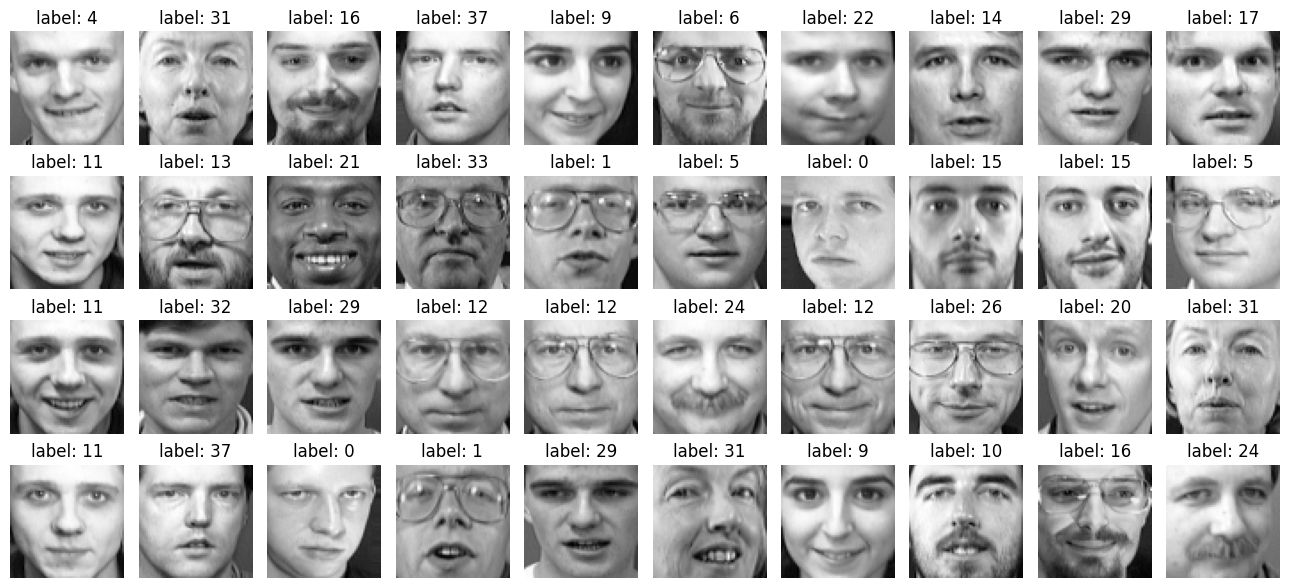

Images to trin total 240


In [108]:
fig, ax = plt.subplots(4,10,figsize=(13,6))
for i in range(40):
    ax[i//10,i%10].imshow(X_train[i],cmap='gray')
    ax[i//10,i%10].set_title('label: '+str(y_train[i]))
    ax[i//10,i%10].axis('off')

plt.tight_layout()
plt.show()

print('Images to trin total',X_train.shape[0])


### 1.3 Data augmentation

We will save an X_train and y_train for each augmentation method, so we can compare them.


As all the images seem to be **of the same plane and are equally aligned** (like will be the test too) some of the augmentation methods will not be useful, like rotation, displacement, etc. 


We will try different techniques to augment the data:

* **Flip** : we will flip the images horizontally and vertically.

* **Gaussian noise** : we will add gaussian noise to the images.

* **Shear** : we will shear the images in the horizontal and vertical directions.

* **Sault and pepper noise** : we will add salt and pepper noise to the images.

* **Gamma correction** : we will apply gamma correction to the images.

* **Ecualization** : we will apply ecualization to the images. (i.e. histogram equalization)




#### Lets see how they look an calibrate the parameters of each method.

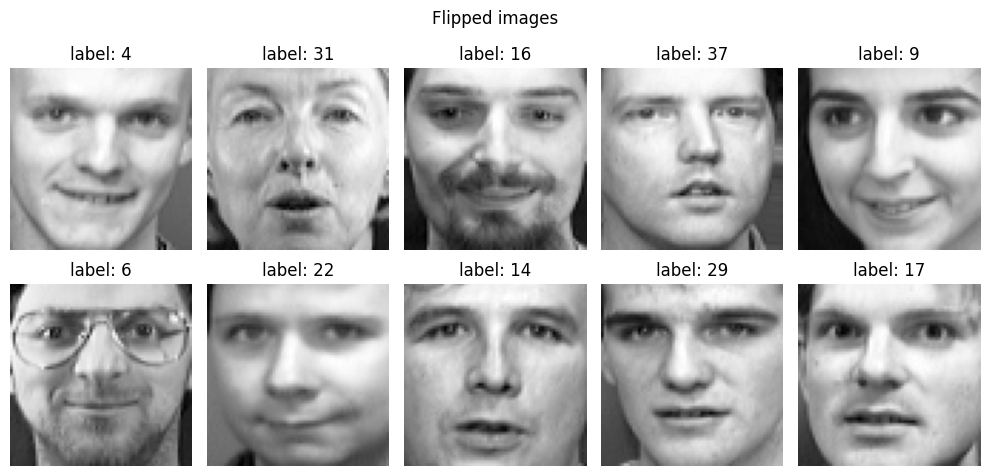

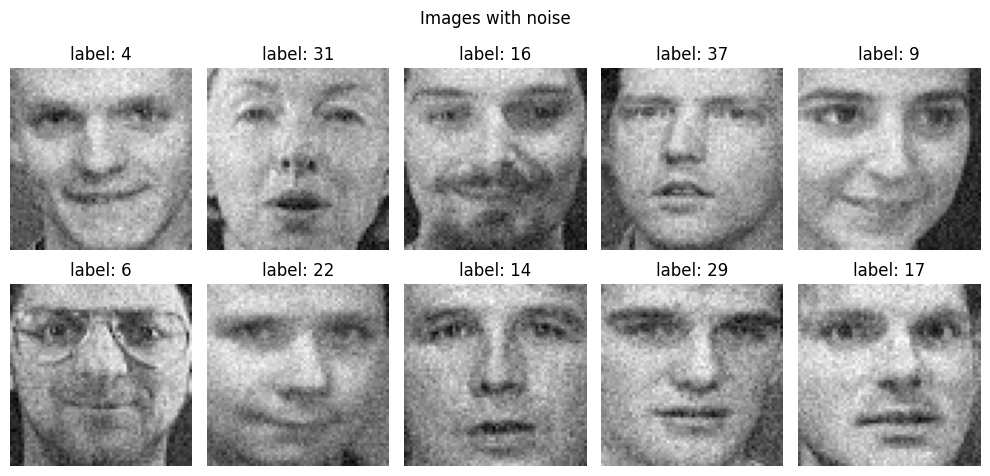

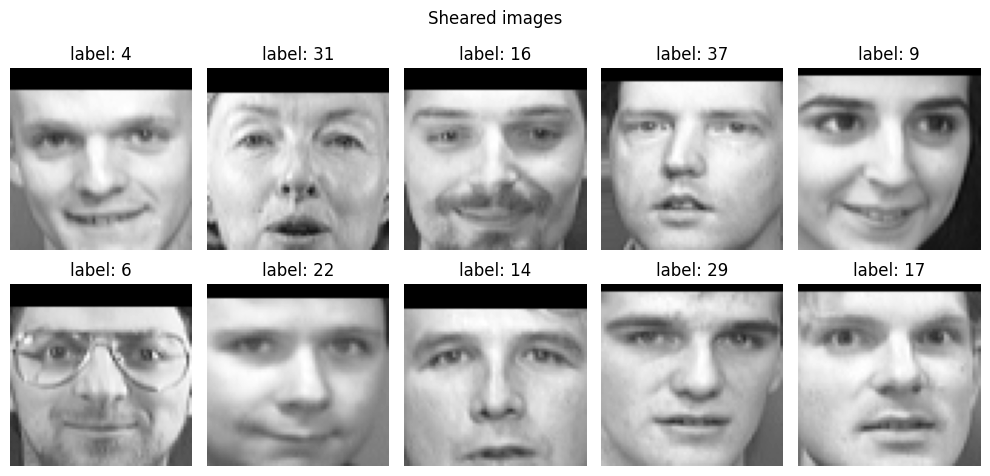

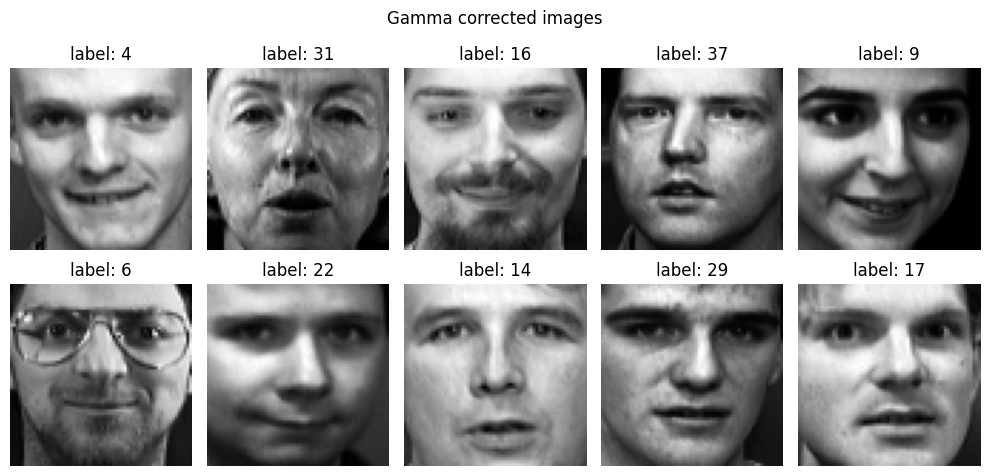

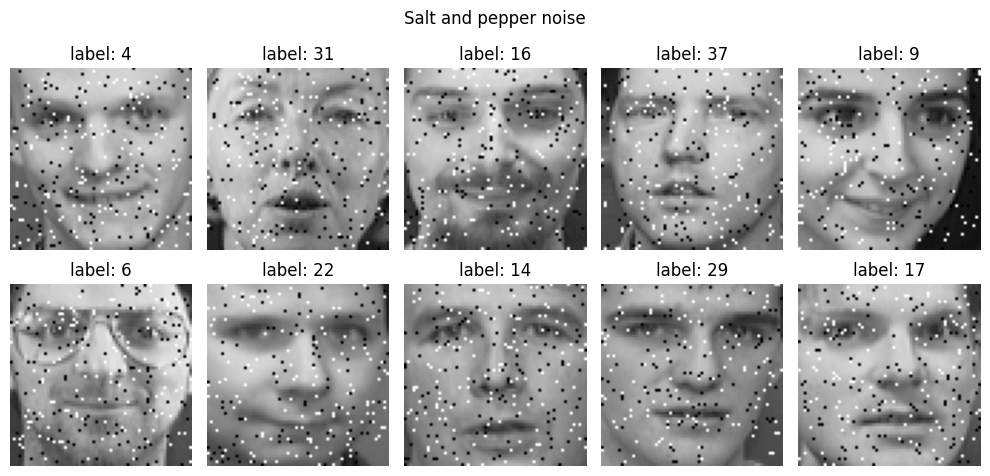

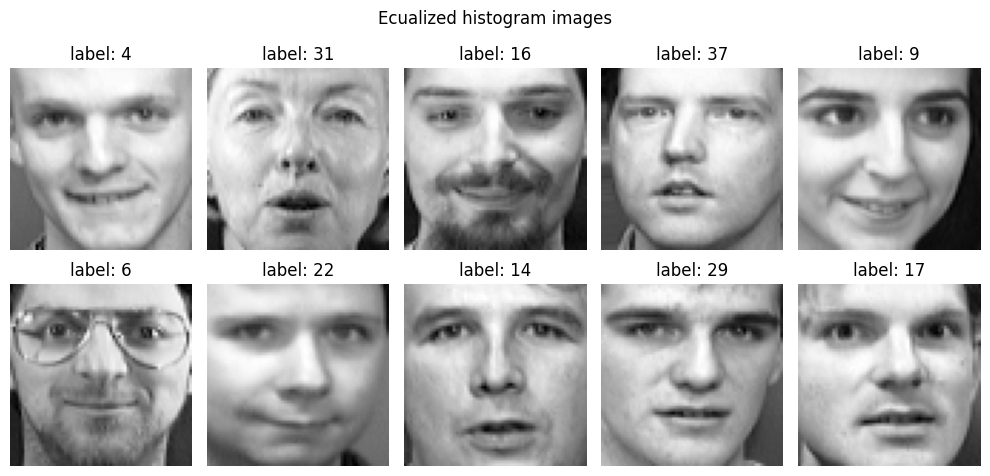

In [109]:
#flip images with numpy
def flip_image(image):
    image = np.fliplr(image)
    return image

fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(flip_image(X_train[i]),cmap='gray')
    ax[i//5,i%5].set_title('label: '+str(y_train[i]))
    ax[i//5,i%5].axis('off')
plt.suptitle('Flipped images')
plt.tight_layout()
plt.show()

#gaussian noise to images with numpy
def add_noise(image):
    image = image + np.random.normal(0,0.05,image.shape)
    return image

fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(add_noise(X_train[i]),cmap='gray')
    ax[i//5,i%5].set_title('label: '+str(y_train[i]))
    ax[i//5,i%5].axis('off')

plt.suptitle('Images with noise')
plt.tight_layout()
plt.show()

#shear images with scipy
from scipy import ndimage
def shear_image(image, shear):
    image = ndimage.shift(image, [shear, 0])
    return image

fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(shear_image(X_train[i],np.random.uniform(10)),cmap='gray')
    ax[i//5,i%5].set_title('label: '+str(y_train[i]))
    ax[i//5,i%5].axis('off')

plt.suptitle('Sheared images')
plt.tight_layout()
plt.show()



#gamma correction with numpy
def gamma_correction(image, gamma):
    image = np.power(image, gamma)
    return image

fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(gamma_correction(X_train[i],np.random.uniform(3)),cmap='gray')
    ax[i//5,i%5].set_title('label: '+str(y_train[i]))
    ax[i//5,i%5].axis('off')

plt.suptitle('Gamma corrected images')
plt.tight_layout()
plt.show()

#sault and pepper noise with numpy
def salt_pepper_noise(image, prob):
    image = image.copy()
    mask = np.random.choice([1,0], size=image.shape, p=[prob, 1-prob])
    image[mask==1] = 0
    mask = np.random.choice([1,0], size=image.shape, p=[prob, 1-prob])
    image[mask==1] = 1

    return image

fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(salt_pepper_noise(X_train[i],0.03),cmap='gray')
    ax[i//5,i%5].set_title('label: '+str(y_train[i]))
    ax[i//5,i%5].axis('off')

plt.suptitle('Salt and pepper noise')
plt.tight_layout()
plt.show()

#ecualize image with numpy
def ecualize_histogram(image):
    image = image - np.min(image)
    image = image / np.max(image)
    return image

fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(ecualize_histogram(X_train[i]),cmap='gray')
    ax[i//5,i%5].set_title('label: '+str(y_train[i]))
    ax[i//5,i%5].axis('off')

plt.suptitle('Ecualized histogram images')
plt.tight_layout()
plt.show()


#### Now we will create a new dataset with the transformations we have done

In [110]:
X_flip = np.array([flip_image(image) for image in X_train])
y_flip = y_train
X_gaussian = np.array([add_noise(image) for image in X_train])
y_gaussian = y_train
X_shear = np.array([shear_image(image,np.random.uniform(10)) for image in X_train])
y_shear = y_train
X_gamma = np.array([gamma_correction(image,np.random.uniform(3)) for image in X_train])
y_gamma = y_train
X_salt_pepper = np.array([salt_pepper_noise(image,0.03) for image in X_train])
y_salt_pepper = y_train
X_ecualize = np.array([ecualize_histogram(image) for image in X_train])
y_ecualize = y_train

X_augtrain = np.concatenate((X_train,X_flip,X_gaussian,X_shear,X_gamma,X_salt_pepper,X_ecualize))
y_augtrain = np.concatenate((y_train,y_flip,y_gaussian,y_shear,y_gamma,y_salt_pepper,y_ecualize))
print('Augmented images to train total',X_augtrain.shape[0])

Augmented images to train total 1680


## 2. Classic ML Classification




The aproach we will use is the following:
* Reduce the dimensionality of the data using PCA
* Use a classifier to classify the data

In [138]:
#Flatten  images
X_augtrain = X_augtrain.reshape(X_augtrain.shape[0],-1)
X_train = X_train.reshape(X_train.shape[0],-1)
X_valid = X_valid.reshape(X_valid.shape[0],-1)

### 2.1 PCA dimensionality reduction 


#### Over the non-augmented data (X_train) and the augmented data (X_augtrain)
* We reduce the dimensionality of the data using PCA to 98% of the variance
* With correponding reduction of the validation tests

In [139]:
#PCA non-augmented data & scaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
#X_train_pca=StandardScaler().fit_transform(X_train_pca)
print('NA n components',pca.n_components_)
X_valid_pca = pca.transform(X_valid)

#PCA augmented data
pcag = PCA(n_components=0.98)
pcag.fit(X_augtrain)
X_augtrain_pca = pcag.transform(X_augtrain)
#X_augtrain_pca=StandardScaler().fit_transform(X_augtrain_pca)
print('A n components',pcag.n_components_)
X_valid_augpca = pcag.transform(X_valid)


NA n components 95
A n components 471


### 2.2 Testing the classifiers 


We are goin to try:
* **SVM** : Support Vector Machine
* **RF** : Random Forest
* **LR** : Logistic Regression
* **KNN** : K-Nearest Neighbors

* Lets define a cross validation custom function to evaluate the models

In [107]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

def CV(model,X,y):
    scores = cross_validate(model, X ,y, cv=4, scoring='f1_macro',return_train_score=True)
    print('(using f1_macro)')
    print('cv train',scores['train_score'])
    print('cv test ',scores['test_score'])
    print('cv',scores['test_score'].mean())

In [108]:
# SVM
from sklearn.svm import SVC

svm = SVC(kernel='rbf',C=10,gamma=0.001)
svm.fit(X_train_pca,y_train)

#cross validate + validation test
print('Non-augmented data:')
CV(svm,X_train_pca,y_train)
print('SVM accuracy on validation',f1_score(svm.predict(X_valid_pca),y_valid,average='macro'),'\n')


svm = SVC(kernel='rbf',C=10,gamma=0.001)
svm.fit(X_augtrain_pca,y_augtrain)

#cross validate + validation test
scores = cross_validate(svm, X_augtrain_pca, y_augtrain, cv=5, scoring='accuracy')
print('Augmented data:')
CV(svm,X_augtrain_pca,y_augtrain)
print('SVM accuracy on validation',f1_score(svm.predict(X_valid_augpca),y_valid,average='macro'),'\n')



Non-augmented data:
(using f1_macro)
cv train [1. 1. 1. 1.]
cv test  [0.81416667 0.91833333 0.85416667 0.95333333]
cv 0.885
SVM accuracy on validation 0.9608333333333334 

Augmented data:
(using f1_macro)
cv train [0.9984119  0.99759242 0.99529311 0.99605321]
cv test  [0.91724832 0.89051038 0.52635957 0.9617823 ]
cv 0.8239751442885693
SVM accuracy on validation 0.9866666666666667 



In [109]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,max_depth=5)
rf.fit(X_train_pca,y_train)

#cross validate + validation test
print('Non-augmented data:')
CV(rf,X_train_pca,y_train)
print('RF accuracy on validation',f1_score(rf.predict(X_valid_pca),y_valid,average='macro'),'\n')


rf = RandomForestClassifier(n_estimators=100,max_depth=5)
rf.fit(X_augtrain_pca,y_augtrain)

#cross validate + validation test
print('Augmented data:')
CV(rf,X_augtrain_pca,y_augtrain)
print('RF accuracy on validation',f1_score(rf.predict(X_valid_augpca),y_valid,average='macro'),'\n')


Non-augmented data:
(using f1_macro)
cv train [1. 1. 1. 1.]
cv test  [0.5725     0.63       0.54       0.78166667]
cv 0.6310416666666667
RF accuracy on validation 0.8141666666666666 

Augmented data:
(using f1_macro)
cv train [0.96985391 0.97321906 0.98256014 0.95605336]
cv test  [0.90956915 0.75240162 0.69421774 0.96787815]
cv 0.8310166626769562
RF accuracy on validation 0.8799999999999999 



In [110]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=3,max_iter=1000)
lr.fit(X_train_pca,y_train)

#cross validate + validation test
print('Non-augmented data:')
CV(lr,X_train_pca,y_train)
print('LR accuracy on validation',f1_score(lr.predict(X_valid_pca),y_valid,average='macro'),'\n')


lr = LogisticRegression(C=3,max_iter=1000)
lr.fit(X_augtrain_pca,y_augtrain)

#cross validate + validation test
print('Augmented data:')
CV(lr,X_augtrain_pca,y_augtrain)
print('LR accuracy on validation',f1_score(lr.predict(X_valid_augpca),y_valid,average='macro'),'\n')

Non-augmented data:
(using f1_macro)
cv train [1. 1. 1. 1.]
cv test  [0.89916667 0.95166667 0.91166667 0.95333333]
cv 0.9289583333333333
LR accuracy on validation 0.9616666666666667 

Augmented data:
(using f1_macro)
cv train [1. 1. 1. 1.]
cv test  [0.93864848 0.90928856 0.58087942 1.        ]
cv 0.8572041150738654
LR accuracy on validation 0.9866666666666667 



In [111]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_pca,y_train)

#cross validate + validation test
print('Non-augmented data:')
CV(knn,X_train_pca,y_train)
print('KNN accuracy on validation',f1_score(knn.predict(X_valid_pca),y_valid,average='macro'),'\n')


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_augtrain_pca,y_augtrain)

#cross validate + validation test
print('Augmented data:')
CV(knn,X_augtrain_pca,y_augtrain)
print('KNN accuracy on validation',f1_score(knn.predict(X_valid_augpca),y_valid,average='macro'),'\n')


Non-augmented data:
(using f1_macro)
cv train [0.71322035 0.63899817 0.59366392 0.59750835]
cv test  [0.39       0.5072619  0.60916667 0.43630952]
cv 0.48568452380952376
KNN accuracy on validation 0.608095238095238 

Augmented data:
(using f1_macro)
cv train [0.90585966 0.93381606 0.9515595  0.90871364]
cv test  [0.88240403 0.79441114 0.4684318  0.96697185]
cv 0.7780547047364363
KNN accuracy on validation 0.9599999999999997 



### 2.3 Model selection
After trying SVM, Random Forest, Logistic Regression and KNN with default parameters we saw **augmented data had better results in each one of the cases**, so it also helps in classic ML.

I decided to use SVM as my final model, because it had the best results in the cross validation (prior beta test) with out overfiting (in the non augmented data case), and it is a good model for classification problems.

### 2.4 Fine tuning
To fine tune the model we use grid search with cross validation, and also we will use the validation set to evaluate the model. Again using the non-augmented data and the augmented data.


In [132]:
#grid search to find best parameters for SVM
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.1,1,10,100,1000], 'gamma': [0.1,0.01,0.001,0.0001], 'kernel': ['rbf','poly', 'sigmoid','linear']}


#Non augmented data
print('Non-augmented data:')
grid = GridSearchCV(SVC(),param_grid,verbose=0,cv=4)
grid.fit(X_train_pca,y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print('SVM accuracy on validation',f1_score(grid.predict(X_valid_pca),y_valid,average='macro'),'\n')

Non-augmented data:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)
SVM accuracy on validation 0.96 



### 2.5 Final model: SVM with PCA


#### Non-augmented data parameter grid serch: SVM with PCA (98%): {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
* We are going to keep the parameters of the grid search that validated over the non-augmented data, for the same reasosns we explained before, (expecting the same distribution in the testing set and future data).
* We are going to train the final model with both the augmented and non-augmented data, and compare the results over the validation set.

In [133]:
#beta model
svm1 = SVC(kernel='rbf',C=10,gamma=00.01)
svm1.fit(X_train_pca,y_train)
svm2 = SVC(kernel='rbf',C=10,gamma=00.01)
svm2.fit(X_augtrain_pca,y_augtrain)

SVC(C=10, gamma=0.01)

In [134]:
#Validation test
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

print('Non-augmented data:')
print('SVM NA accuracy on validation',accuracy_score(svm1.predict(X_valid_pca),y_valid))
print('SVM NA f1_score on validation',f1_score(svm1.predict(X_valid_pca),y_valid,average='macro'),'\n')

print('Augmented data:')
print('SVM A accuracy on validation',accuracy_score(svm2.predict(X_valid_augpca),y_valid))
print('SVM A f1_score on validation',f1_score(svm2.predict(X_valid_augpca),y_valid,average='macro'),'\n')


Non-augmented data:
SVM NA accuracy on validation 0.9625
SVM NA f1_score on validation 0.96 

Augmented data:
SVM A accuracy on validation 0.9625
SVM A f1_score on validation 0.9533333333333334 



### 2.6 Test score


In [135]:
from sklearn.metrics import f1_score,accuracy_score


#final model non augmented data
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0],-1))
y_pred = svm1.predict(X_test_pca)


#final model augmented data
X_augtest_pca = pcag.transform(X_test.reshape(X_test.shape[0],-1))
y_predag = svm2.predict(X_augtest_pca)



#final score
print('f1 score:')
print('Final score non-augmented:',f1_score(y_pred,y_test,average='macro'))
print('Final score augmented data:',f1_score(y_predag,y_test,average='macro'))

#final score accuracy
print('accuracy score:')
print('Final score non-augmented data:',accuracy_score(y_pred,y_test))
print('Final score augmented data:',accuracy_score(y_predag,y_test))


f1 score:
Final score non-augmented: 0.9292857142857143
Final score augmented data: 0.96
accuracy score:
Final score non-augmented data: 0.9375
Final score augmented data: 0.9625


#### We save the best model 

In [136]:
#pickle model
with open('models/Classic.pkl', 'wb') as f:
    pickle.dump(svm2, f)

## 3. Deep Learning Classification


#### Objetive:
* Create a CNN to classify the images with a base line f-score of $0.93$ (which is indeed a pretty good score).

In [111]:
#undo flatten in train set, validation set and test set
X_train = X_train.reshape(X_train.shape[0],64,64)
X_augtrain = X_augtrain.reshape(X_augtrain.shape[0],64,64)
X_valid = X_valid.reshape(X_valid.shape[0],64,64)
X_test = X_test.reshape(X_test.shape[0],64,64)

### 3.1 CNN architecture 

In order to create a CNN we need to define the architecture of the network. We will use the following architecture (was designed by me and ilustrated with this online [drawing tool](http://alexlenail.me/NN-SVG/LeNet.html)):

![CNN architecture](\cnn.svg)


### 3.2 Implementation of the model 

In [13]:
from tensorflow.keras import layers, models

In [37]:
CNN= models.Sequential()

CNN= models.Sequential()

CNN.add(layers.Conv2D(128, 3, activation='relu', input_shape=(64, 64, 1)))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(256, 3, activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(512, 3, activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(256, activation='relu'))
CNN.add(layers.Dense(40, activation='softmax'))

CNN.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


CNN.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 62, 62, 128)       1280      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 256)       295168    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 512)       1180160   
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 512)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)           

### 3.3 Overfitting


#### Let's prove the model can overfit 
* Using the train data as "validation" we expect to get a perfect score

In [112]:
#add channel dimension to train set
X_train = X_train.reshape(X_train.shape[0],64,64,1)
X_augtrain = X_augtrain.reshape(X_augtrain.shape[0],64,64,1)
X_valid = X_valid.reshape(X_valid.shape[0],64,64,1)
X_test = X_test.reshape(X_test.shape[0],64,64,1)

In [42]:
CNN.fit(X_train,y_train,epochs=10,batch_size=40,validation_data=(X_train,y_train))

Epoch 1/10
6/6 [==============================] - 1s 126ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 1s 102ms/step - loss: 9.8803e-04 - accuracy: 1.0000 - val_loss: 9.3414e-04 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 1s 101ms/step - loss: 9.2479e-04 - accuracy: 1.0000 - val_loss: 8.6932e-04 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 1s 102ms/step - loss: 8.5773e-04 - accuracy: 1.0000 - val_loss: 8.1986e-04 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 1s 102ms/step - loss: 8.0848e-04 - accuracy: 1.0000 - val_loss: 7.7461e-04 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 1s 101ms/step - loss: 7.6901e-04 - accuracy: 1.0000 - val_loss: 7.3578e-04 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 102ms/step - loss: 7.3619e-04 - accuracy: 1.0000 - val_loss: 7.0167

* With the non augmented data it overtfits perfectly, lets try with the augmented data.

In [43]:
CNN.fit(X_augtrain,y_augtrain,epochs=10,validation_data=(X_augtrain,y_augtrain))

Epoch 1/10
53/53 [==============================] - 4s 80ms/step - loss: 1.9295 - accuracy: 0.5994 - val_loss: 0.7718 - val_accuracy: 0.8238
Epoch 2/10
53/53 [==============================] - 4s 76ms/step - loss: 0.5052 - accuracy: 0.8679 - val_loss: 0.3308 - val_accuracy: 0.9238
Epoch 3/10
53/53 [==============================] - 4s 77ms/step - loss: 0.2736 - accuracy: 0.9202 - val_loss: 0.1362 - val_accuracy: 0.9667
Epoch 4/10
53/53 [==============================] - 4s 76ms/step - loss: 0.1665 - accuracy: 0.9458 - val_loss: 0.1084 - val_accuracy: 0.9690
Epoch 5/10
53/53 [==============================] - 4s 76ms/step - loss: 0.1287 - accuracy: 0.9643 - val_loss: 0.0667 - val_accuracy: 0.9857
Epoch 6/10
53/53 [==============================] - 4s 76ms/step - loss: 0.0548 - accuracy: 0.9833 - val_loss: 0.0305 - val_accuracy: 0.9917
Epoch 7/10
53/53 [==============================] - 4s 77ms/step - loss: 0.0285 - accuracy: 0.9923 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 8/10
53

It also can **overfit the augmented data**, so the model is representative of the data.

### 3.4 Regularization


#### We are going to rebuild the CNN model with **dropout layers** to avoid overfitting

In [113]:
CNN= models.Sequential()

CNN.add(layers.Conv2D(128, 3, activation='relu', input_shape=(64, 64, 1)))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Dropout(0.2))
CNN.add(layers.Conv2D(256, 3, activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Dropout(0.2))
CNN.add(layers.Conv2D(512, 3, activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Dropout(0.2))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(256, activation='relu'))
CNN.add(layers.Dense(40, activation='softmax'))

CNN.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
                
#CNN.summary()

#### Let's train see if gets difficult to overfit

In [114]:
CNN.fit(X_train,y_train,epochs=10,validation_data=(X_train,y_train))

Epoch 1/10
8/8 [==============================] - 2s 101ms/step - loss: 3.7625 - accuracy: 0.0125 - val_loss: 3.6886 - val_accuracy: 0.0250
Epoch 2/10
8/8 [==============================] - 1s 82ms/step - loss: 3.6897 - accuracy: 0.0208 - val_loss: 3.6887 - val_accuracy: 0.0250
Epoch 3/10
8/8 [==============================] - 1s 82ms/step - loss: 3.6894 - accuracy: 0.0167 - val_loss: 3.6885 - val_accuracy: 0.0250
Epoch 4/10
8/8 [==============================] - 1s 82ms/step - loss: 3.6892 - accuracy: 0.0167 - val_loss: 3.6885 - val_accuracy: 0.0250
Epoch 5/10
8/8 [==============================] - 1s 82ms/step - loss: 3.6881 - accuracy: 0.0292 - val_loss: 3.6872 - val_accuracy: 0.0250
Epoch 6/10
8/8 [==============================] - 1s 82ms/step - loss: 3.6888 - accuracy: 0.0208 - val_loss: 3.6838 - val_accuracy: 0.0292
Epoch 7/10
8/8 [==============================] - 1s 82ms/step - loss: 3.6839 - accuracy: 0.0333 - val_loss: 3.6783 - val_accuracy: 0.0333
Epoch 8/10
8/8 [==========

### 3.5 Train the CNN 

#### Now it its time to do the train using the validation set. 

* Using **early stopping** to have another regularization method.

* And **model checkpoint** to save the best model we can get. So even if we dont stop the training at the right moment, we will have the best model saved.

* We will sitch between epochs of training with random augmented data with the ImageDataGenerator, and epochs with oour previous augmented data, but early stoppieng.

In [115]:
#train model with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(monitor='val_loss',patience=10)

#chekpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [129]:
#data augmentation in training set (1 channel)
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        data_format='channels_last',
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=add_noise
        )

CNN.fit(datagen.flow(X_train, y_train, batch_size=40),    
                    steps_per_epoch=len(X_train) / 40, epochs=100,
                    validation_data=(X_valid, y_valid),callbacks=[checkpoint])

Epoch 1/100
6/6 [==============================] - 1s 101ms/step - loss: 1.8973 - accuracy: 0.5542 - val_loss: 0.5748 - val_accuracy: 0.8500

Epoch 00001: val_loss did not improve from 0.10186
Epoch 2/100
6/6 [==============================] - 1s 92ms/step - loss: 1.2833 - accuracy: 0.6125 - val_loss: 0.3093 - val_accuracy: 0.9625

Epoch 00002: val_loss did not improve from 0.10186
Epoch 3/100
6/6 [==============================] - 1s 92ms/step - loss: 0.9180 - accuracy: 0.7292 - val_loss: 0.1824 - val_accuracy: 0.9750

Epoch 00003: val_loss did not improve from 0.10186
Epoch 4/100
6/6 [==============================] - 1s 92ms/step - loss: 0.6797 - accuracy: 0.7792 - val_loss: 0.1430 - val_accuracy: 0.9750

Epoch 00004: val_loss did not improve from 0.10186
Epoch 5/100
6/6 [==============================] - 1s 92ms/step - loss: 0.5969 - accuracy: 0.8208 - val_loss: 0.1487 - val_accuracy: 0.9875

Epoch 00005: val_loss did not improve from 0.10186
Epoch 6/100
6/6 [======================

In [133]:
CNN.fit(X_augtrain,y_augtrain,epochs=10,batch_size=10,validation_data=(X_valid,y_valid),callbacks=[early_stopping_monitor,checkpoint])

Epoch 1/10
168/168 [==============================] - 5s 31ms/step - loss: 0.1685 - accuracy: 0.9435 - val_loss: 0.3100 - val_accuracy: 0.9375

Epoch 00001: val_loss did not improve from 0.09745
Epoch 2/10
168/168 [==============================] - 5s 30ms/step - loss: 0.1043 - accuracy: 0.9679 - val_loss: 0.2149 - val_accuracy: 0.9250

Epoch 00002: val_loss did not improve from 0.09745
Epoch 3/10
168/168 [==============================] - 5s 30ms/step - loss: 0.0738 - accuracy: 0.9804 - val_loss: 0.1585 - val_accuracy: 0.9375

Epoch 00003: val_loss did not improve from 0.09745
Epoch 4/10
168/168 [==============================] - 5s 30ms/step - loss: 0.0358 - accuracy: 0.9917 - val_loss: 0.0728 - val_accuracy: 0.9750

Epoch 00004: val_loss improved from 0.09745 to 0.07282, saving model to best_model.h5
Epoch 5/10
168/168 [==============================] - 5s 30ms/step - loss: 0.0763 - accuracy: 0.9786 - val_loss: 0.2294 - val_accuracy: 0.9375

Epoch 00005: val_loss did not improve fro

In [134]:
# Test the model on validation using the best model
from sklearn.metrics import f1_score

CNN.load_weights('best_model.h5')
score = CNN.evaluate(X_valid, y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
y_pred = CNN.predict(X_valid)
y_pred = np.argmax(y_pred,axis=1)
print('F1 score:',f1_score(y_pred,y_valid,average='macro'))


Validation loss: 0.07281710207462311
Validation accuracy: 0.9750000238418579
F1 score: 0.9733333333333333


### 3.6 Test the CNN

In [135]:
score = CNN.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = CNN.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print('F1 score:',f1_score(y_pred,y_test,average='macro'))

Test loss: 0.3875153064727783
Test accuracy: 0.949999988079071
F1 score: 0.9474999999999998


In [136]:
#save model
CNN.save('models/CNN.h5')

## 4. Transfer Learning



In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2015243602444361223
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1310523188
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11380913941621374048
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


#### 4.1 Architecture of the VGG16 model

![VGG16](https://www.researchgate.net/publication/328966158/figure/fig2/AS:693278764720129@1542301946576/An-overview-of-the-VGG-16-model-architecture-this-model-uses-simple-convolutional-blocks.png)

#### Layers of the VGG16 model

![VGG16L](https://miro.medium.com/max/861/0*6VP81rFoLWp10FcG)

#### 4.2 VGG16 + new layers 
(for our classification problem)


In [61]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [62]:
#we are not including the top of the model, so we can add our own layers
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(64,64,3))

#freeze all layers
base_model.trainable=False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [70]:
from tensorflow.keras import layers, models

#add our own layers
model=models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(40,activation='softmax'))


model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 40)                10280     
Total params: 15,249,512
Trainable params: 534,824
Non-trainable params: 14,714,688
____________________________________

In [71]:
#now lets compile the model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#chekpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_tmodel.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

### 4.3 Train


In [72]:
#Create 3 channels for the images
X_valid3 = np.empty((X_valid.shape[0],64,64,3))
X_test3 = np.empty((X_test.shape[0],64,64,3))
X_train3 = np.empty((X_train.shape[0],64,64,3))
X_augtrain3 = np.empty((X_augtrain.shape[0],64,64,3))

#add the 3 channels
for i in range(X_valid.shape[0]):
    X_valid3[i,:,:,0] = X_valid[i].copy()
    X_valid3[i,:,:,1] = X_valid[i].copy()
    X_valid3[i,:,:,2] = X_valid[i].copy()

for i in range(X_test.shape[0]):
    X_test3[i,:,:,0] = X_test[i].copy()
    X_test3[i,:,:,1] = X_test[i].copy()
    X_test3[i,:,:,2] = X_test[i].copy()

for i in range(X_train.shape[0]):
    X_train3[i,:,:,0] = X_train[i].copy()
    X_train3[i,:,:,1] = X_train[i].copy()
    X_train3[i,:,:,2] = X_train[i].copy()

for i in range(X_augtrain.shape[0]):
    X_augtrain3[i,:,:,0] = X_augtrain[i].copy()
    X_augtrain3[i,:,:,1] = X_augtrain[i].copy()
    X_augtrain3[i,:,:,2] = X_augtrain[i].copy()



In [78]:
model.fit(X_augtrain3,y_augtrain,epochs=100,validation_data=(X_valid3,y_valid),callbacks=[checkpoint])

Epoch 1/100
53/53 [==============================] - 3s 57ms/step - loss: 0.6744 - accuracy: 0.8381 - val_loss: 0.1383 - val_accuracy: 0.9625

Epoch 00001: val_loss did not improve from 0.07612
Epoch 2/100
53/53 [==============================] - 3s 57ms/step - loss: 0.2958 - accuracy: 0.9125 - val_loss: 0.1248 - val_accuracy: 0.9625

Epoch 00002: val_loss did not improve from 0.07612
Epoch 3/100
53/53 [==============================] - 3s 57ms/step - loss: 0.1912 - accuracy: 0.9446 - val_loss: 0.1028 - val_accuracy: 0.9625

Epoch 00003: val_loss did not improve from 0.07612
Epoch 4/100
53/53 [==============================] - 3s 57ms/step - loss: 0.1393 - accuracy: 0.9565 - val_loss: 0.0571 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.07612 to 0.05707, saving model to best_tmodel.h5
Epoch 5/100
53/53 [==============================] - 3s 57ms/step - loss: 0.1458 - accuracy: 0.9577 - val_loss: 0.1022 - val_accuracy: 0.9625

Epoch 00005: val_loss did not improve from 0.

### 4.4 Test the model

In [86]:
from sklearn.metrics import f1_score

model.load_weights('best_tmodel.h5')
#test the model
score = model.evaluate(X_test3, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test3)
y_pred = np.argmax(y_pred,axis=1)
print('F1 score:',f1_score(y_pred,y_test,average='macro'))

Test loss: 0.2820456624031067
Test accuracy: 0.9624999761581421
F1 score: 0.9599999999999997


In [87]:
#save model
model.save('Models/VGG16.h5')

## 5. Results

Type | Model | Accuracy | F-score 
---|---|---|---
Classic ML | SVM with PCA | 0.9625 | 0.96
Deep Learning | custom CNN | 0.95 | 0.9475
Transfer Learning | VGG16 + new layers | 0.9625 | 0.96


## 6. Conclusion




First we saw at each step of the process, the augmented data was better than the non-augmented data (or at it never got worse). So we decided to use the augmented data for each model.
We divided the data in train, validation and test sets, doing data augmentation only on the train set. We used the validation set to evaluate the models after getting the last parameters of each type of model, and the test set to evaluate the final stage.

Despite being an image classification job with few data, classic machine learning turned out to be a fast and light alternative, especially due to the reduction of the dimensionality from 4096 to 471. The CNN model was also a good alternative, but it was more complex and time consuming to train, and it was not as accurate as the classic ML model. The transfer learning model was accurate as the classic ML model, but it was more complex and time consuming to train.

A possible reason of this resutls culd be the small amount of data, and the low variance of the images. All the images seem to be of the same plane and are equally aligned. So in that case, the classic ML model was able to learn the features of the images in a simpler way than a complex CNN model. This show us that the classic ML models are still a good alternative for image classification problems, specially when the data is small and the images are similar.

Futhermore, the augmented data was a good alternative to increase the amount of data, and it was also a good alternative to increase the variance of the data, so the models could learn more features of the images.

Finally, doing a comparison between the two CNN models, the transfer learning model was more accurate and easier to train.